In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import random
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import Callback

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

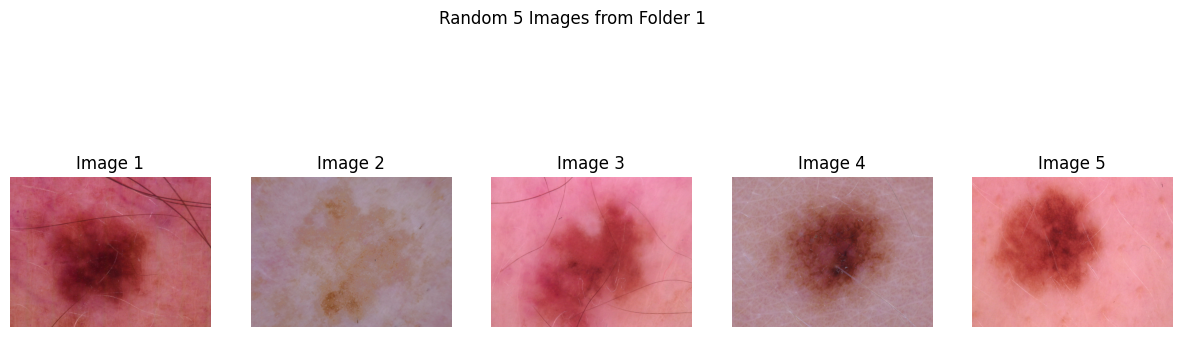

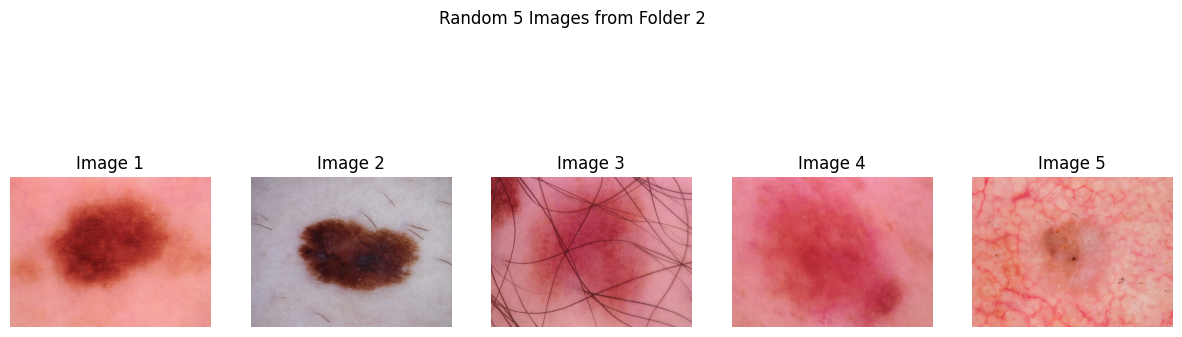

In [44]:


folder1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
folder2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

images1 = [os.path.join(folder1, f) for f in os.listdir(folder1) if f.endswith('.jpg')]
images2 = [os.path.join(folder2, f) for f in os.listdir(folder2) if f.endswith('.jpg')]

random_images1 = random.sample(images1, 5)
random_images2 = random.sample(images2, 5)

def display_images(images, title):
    plt.figure(figsize=(15, 5))  # Adjust the figure size
    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)  # Create a subplot for each image
        plt.imshow(img)
        plt.axis('off')  # Turn off the axis
        plt.title(f"Image {i + 1}")
    plt.suptitle(title)
    plt.show()

display_images(random_images1, "Random 5 Images from Folder 1")
display_images(random_images2, "Random 5 Images from Folder 2")


In [45]:
tabular_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

print(tabular_data.head())

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [46]:
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')

In [47]:
x = data.drop('label', axis=1)
y = data['label']

In [48]:
import numpy as np
import tensorflow as tf
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

oversample = RandomOverSampler(random_state=SEED)
x_resampled, y_resampled = oversample.fit_resample(x, y)
x_resampled = np.array(x_resampled).reshape(-1, 28, 28, 3).astype(np.float32)

mean = np.mean(x_resampled)
std = np.std(x_resampled)
x_resampled = (x_resampled - mean) / std

num_augmented_samples = int(0.005 * len(x_resampled))
rng = np.random.default_rng(SEED)
indices = rng.choice(len(x_resampled), num_augmented_samples, replace=False)
x_selected = x_resampled[indices].astype(np.float32)
y_selected = y_resampled[indices]

augmenters = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-10, 10)),
    iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),
    iaa.Crop(percent=(0, 0.2)),
    iaa.Affine(shear=(-5, 5)),
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.01*255)),
    iaa.LinearContrast((0.9, 1.1)),
    iaa.Resize({"height": "keep-aspect-ratio", "width": 256})
], random_order=True).to_deterministic()

x_augmented = augmenters(images=x_selected)
x_augmented_resized = np.array([tf.image.resize(img, (28, 28)).numpy() for img in x_augmented])

x_resampled = np.concatenate((x_resampled, x_augmented_resized), axis=0)
y_resampled = np.concatenate((y_resampled, y_selected), axis=0)

X_train, X_test, Y_train, Y_test = train_test_split(
    x_resampled, y_resampled, test_size=0.2, random_state=SEED
)

print(f'Training set size: {X_train.shape}, Testing set size: {X_test.shape}')


Training set size: (37735, 28, 28, 3), Testing set size: (9434, 28, 28, 3)


In [49]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import Callback

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
rng = np.random.default_rng(SEED)

class CustomLearningRateScheduler(Callback):
    def __init__(self, h=1.0, m_range=10, patience=3, random_factor=0.1, decay_rate=0.98, warmup_epochs=5, min_lr=1e-6, max_adjustment=0.0005, verbose=0):
        super(CustomLearningRateScheduler, self).__init__()
        self.h = h
        self.m_range = m_range
        self.patience = patience
        self.random_factor = random_factor
        self.decay_rate = decay_rate
        self.warmup_epochs = warmup_epochs
        self.min_lr = min_lr
        self.max_adjustment = max_adjustment
        self.verbose = verbose
        self.best_loss = float('inf')
        self.loss_history = []

    def compute_adjustment_factor(self, logs):
        current_loss = logs.get("loss", 1.0)
        g = lambda x: tf.nn.relu(tf.cast(x, tf.float32))

        adjustment_factor = 0.0
        for m in range(-self.m_range, self.m_range + 1):
            shift = m * self.h
            left_shift = g(-shift)
            right_shift = g(shift)
            adjustment_factor += current_loss * (left_shift - right_shift)

        adjustment_factor *= (self.h / 2)
        adjustment_factor = np.clip(adjustment_factor.numpy(), -self.max_adjustment, self.max_adjustment)
        return adjustment_factor

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        optimizer = self.model.optimizer
        try:
            if isinstance(optimizer.learning_rate, tf.Variable):
                current_lr = tf.keras.backend.get_value(optimizer.learning_rate)
            elif hasattr(optimizer.learning_rate, "numpy"):
                current_lr = optimizer.learning_rate.numpy()
            else:
                current_lr = optimizer.learning_rate
        except Exception as e:
            if self.verbose > 0:
                print(f"Epoch {epoch+1}: Unable to retrieve learning rate. Error: {e}")
            return

        adjustment_factor = self.compute_adjustment_factor(logs)
        self.loss_history.append(logs.get("loss", 1.0))
        if len(self.loss_history) > 3:
            recent_losses = np.array(self.loss_history[-3:])
            if np.all(recent_losses[1:] > recent_losses[:-1]):
                adjustment_factor *= 0.5

        if epoch < self.warmup_epochs:
            new_lr = current_lr * (1 + 0.2 * (epoch / self.warmup_epochs))
        else:
            new_lr = current_lr * self.decay_rate + adjustment_factor

        random_adjustment = 1 + rng.uniform(-self.random_factor, self.random_factor)
        new_lr *= random_adjustment
        new_lr = max(self.min_lr, new_lr)

        try:
            if isinstance(optimizer.learning_rate, tf.Variable):
                tf.keras.backend.set_value(optimizer.learning_rate, new_lr)
            else:
                optimizer.learning_rate = new_lr
        except Exception as e:
            if self.verbose > 0:
                print(f"Epoch {epoch+1}: Unable to set learning rate. Error: {e}")
            return

        if self.verbose > 0:
            print(f"Epoch {epoch+1}: Adjusted LR to {new_lr:.6f}")

In [50]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Define the LeNet-5 model
model = Sequential([
    # First convolutional layer (6 filters, 5x5 kernel, tanh activation)
    Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 3), padding='same'),
    AveragePooling2D(pool_size=(2, 2)),

    # Second convolutional layer (16 filters, 5x5 kernel, tanh activation)
    Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'),
    AveragePooling2D(pool_size=(2, 2)),

    # Flatten the feature maps
    Flatten(),

    # First fully connected layer (120 units, tanh activation)
    Dense(120, activation='tanh'),

    # Second fully connected layer (84 units, tanh activation)
    Dense(84, activation='tanh'),

    # Output layer (7 units, softmax activation for 7 classes)
    Dense(7, activation='softmax')
])


# Summary of the model
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 7)              │           595 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,751 (241.21 KB)

 Trainable params: 61,751 (241.21 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Initial learning rate
    metrics=['accuracy']
)

custom_lr_scheduler = CustomLearningRateScheduler(h=1.0, m_range=2, verbose=1)



In [52]:
import time
start_train_time = time.time()

history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=20,
    callbacks=[custom_lr_scheduler]
)

train_time = time.time() - start_train_time
print(f" training time: {train_time:.2f} seconds")


Epoch 1/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4327 - loss: 1.4554Epoch 1: Adjusted LR to 0.001055
236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.4333 - loss: 1.4541 - val_accuracy: 0.5708 - val_loss: 1.1548
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6031 - loss: 1.0889Epoch 2: Adjusted LR to 0.001084
236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6032 - loss: 1.0886 - val_accuracy: 0.6734 - val_loss: 0.9155
Epoch 3/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7017 - loss: 0.8453Epoch 3: Adjusted LR to 0.001254
236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7019 - loss: 0.8448 - val_accuracy: 0.7529 - val_loss: 0.6875
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7824 - loss: 0.6296Epoch 4: Adjusted LR to 0.001460
236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7825 - loss: 0.6293 - val_accuracy: 0.8173 - val_loss: 0.5284
Epoch 5/20
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/

In [53]:
train_score = model.evaluate(X_train, Y_train, verbose= 1)
test_score = model.evaluate(X_test, Y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9969 - loss: 0.0145
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9696 - loss: 0.1338
Train Loss:  0.03786240518093109
Train Accuracy:  0.9911752939224243
--------------------
Test Loss:  0.14698578417301178
Test Accuracy:  0.9666101336479187


In [55]:
# Define the baseline model
model1 = Sequential([
    # First convolutional layer (6 filters, 5x5 kernel, tanh activation)
    Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 3), padding='same'),
    AveragePooling2D(pool_size=(2, 2)),

    # Second convolutional layer (16 filters, 5x5 kernel, tanh activation)
    Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'),
    AveragePooling2D(pool_size=(2, 2)),

    # Flatten the feature maps
    Flatten(),

    # First fully connected layer (120 units, tanh activation)
    Dense(120, activation='tanh'),

    # Second fully connected layer (84 units, tanh activation)
    Dense(84, activation='tanh'),

    # Output layer (7 units, softmax activation for 7 classes)
    Dense(7, activation='softmax')
])

# Compile the model


# Instantiate the custom learning rate scheduler




In [56]:
from tensorflow.keras.callbacks import LearningRateScheduler

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Triangular Learning Rate Policy
def triangular_lr(epoch, max_lr=0.00178, min_lr=0.00077, stepsize=10):
    """Implements the Triangular CLR policy."""
    cycle = np.floor(1 + epoch / (2 * stepsize))
    x = np.abs(epoch / stepsize - 2 * cycle + 1)
    lr = min_lr + (max_lr - min_lr) * max(0, (1 - x))
    return lr

# Define the LearningRateScheduler Callback
lr_callback = LearningRateScheduler(lambda epoch: triangular_lr(epoch, max_lr=0.00146, min_lr=0.00088, stepsize=10))


model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [57]:
callback = ModelCheckpoint(
    filepath='best_model.keras',  # Changed to .keras extension
    monitor='val_accuracy',       # Monitoring validation accuracy
    verbose=1
)


In [58]:
start_train_time = time.time()

history = model1.fit(
    X_train, Y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=20,
    callbacks=[lr_callback]
)
train_time = time.time() - start_train_time
print(f" training time: {train_time:.2f} seconds")


Epoch 1/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.4031 - loss: 1.5267 - val_accuracy: 0.5706 - val_loss: 1.1563 - learning_rate: 8.8000e-04
Epoch 2/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.5967 - loss: 1.0952 - val_accuracy: 0.6646 - val_loss: 0.9317 - learning_rate: 9.3800e-04
Epoch 3/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6951 - loss: 0.8610 - val_accuracy: 0.7506 - val_loss: 0.7135 - learning_rate: 9.9600e-04
Epoch 4/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.7760 - loss: 0.6558 - val_accuracy: 0.8091 - val_loss: 0.5572 - learning_rate: 0.0011
Epoch 5/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8288 - loss: 0.5022 - val_accuracy: 0.8504 - val_loss: 0.4361 - learning_rate: 0.0011
Epoch 6/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - accuracy: 0.8702 - loss: 0.3885 - val_accuracy: 0.8770 - val_loss: 0.3571 - learning_rate: 0.0012
Epoch 7/20
236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy

In [59]:
train_score = model1.evaluate(X_train, Y_train, verbose= 1)
test_score = model1.evaluate(X_test, Y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9968 - loss: 0.0188
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9672 - loss: 0.1365
Train Loss:  0.041896265000104904
Train Accuracy:  0.9908837676048279
--------------------
Test Loss:  0.1478409618139267
Test Accuracy:  0.9641721248626709


In [ ]:
model.save("best_model.pth")

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step


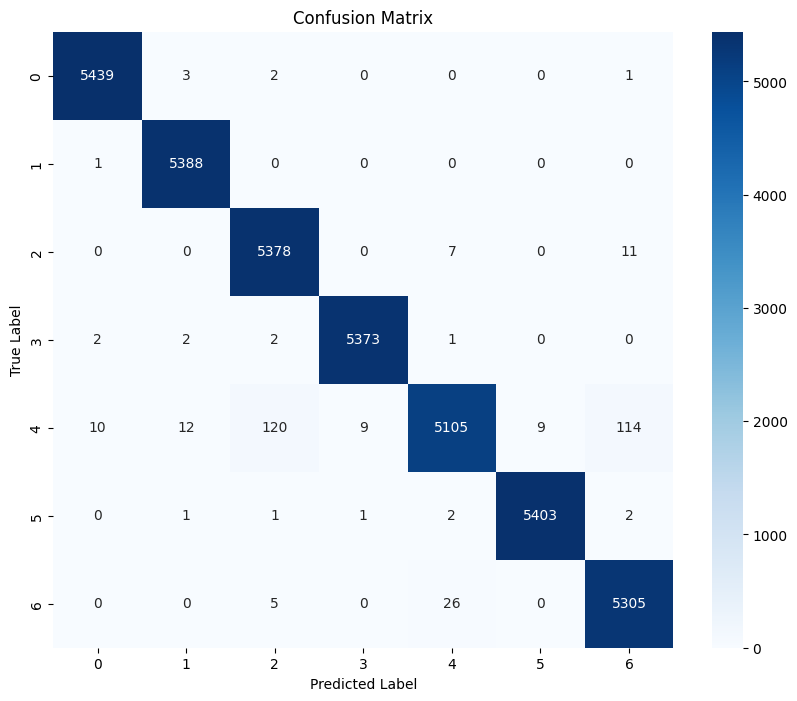

Precision: 0.9910
Recall: 0.9909
Accuracy: 0.9909

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      5445
     Class 1       1.00      1.00      1.00      5389
     Class 2       0.98      1.00      0.99      5396
     Class 3       1.00      1.00      1.00      5380
     Class 4       0.99      0.95      0.97      5379
     Class 5       1.00      1.00      1.00      5410
     Class 6       0.98      0.99      0.99      5336

    accuracy                           0.99     37735
   macro avg       0.99      0.99      0.99     37735
weighted avg       0.99      0.99      0.99     37735



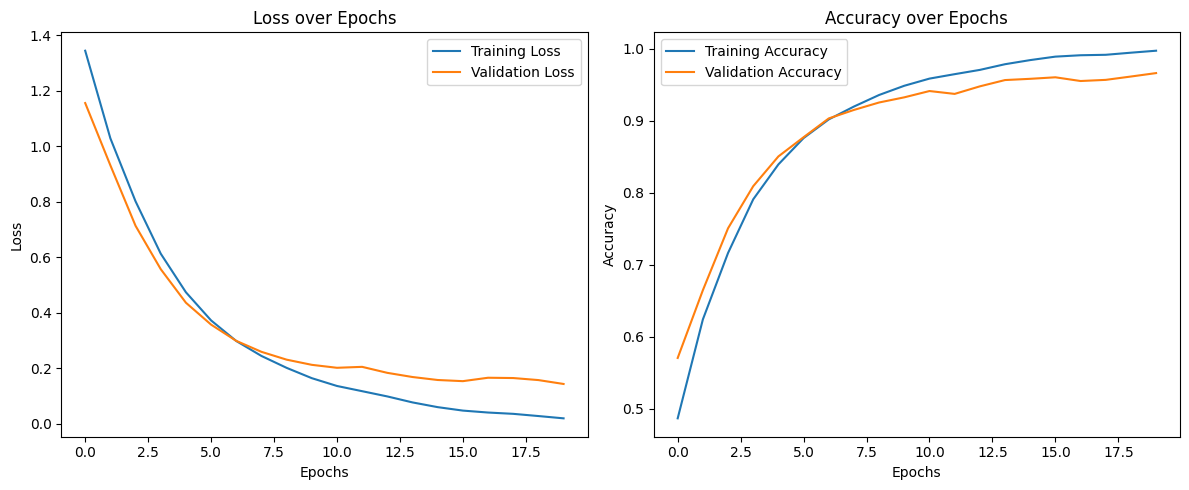

In [63]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Assuming model1 is already trained and X_train, Y_train are defined
# Make predictions on training set (or validation set)
y_pred = model1.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels

# Check the shape of Y_train
if Y_train.ndim == 2:  # If Y_train is one-hot encoded
    y_true = np.argmax(Y_train, axis=1)  # Convert one-hot encoded labels to class indices
else:  # If Y_train is already in class index format
    y_true = Y_train  # Use it directly

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(7), yticklabels=np.arange(7))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and accuracy
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true, y_pred_classes)

# Print the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Optionally, print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=[f'Class {i}' for i in range(7)]))

# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy Plot
if 'accuracy' in history.history:  # For models using accuracy metric
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

plt.tight_layout()
plt.show()